# Tutorial: Simplifying Pipeline Inputs with Multiplexer


- **Level**: Intermediate
- **Time to complete**: 10 minutes
- **Components Used**: [Multiplexer](https://docs.haystack.deepset.ai/v2.0/docs/multiplexer), [InMemoryDocumentStore](https://docs.haystack.deepset.ai/v2.0/docs/inmemorydocumentstore), [HuggingFaceTEIDocumentEmbedder](https://github.com/deepset-ai/haystack/blob/main/haystack/components/embedders/hugging_face_tei_document_embedder.py), [HuggingFaceTEITextEmbedder](https://github.com/deepset-ai/haystack/blob/main/haystack/components/embedders/hugging_face_tei_text_embedder.py), [InMemoryEmbeddingRetriever](https://docs.haystack.deepset.ai/v2.0/docs/inmemoryembeddingretriever), [PromptBuilder](https://docs.haystack.deepset.ai/v2.0/docs/promptbuilder), [HuggingFaceTGIGenerator](https://docs.haystack.deepset.ai/v2.0/docs/huggingfacetgigenerator) and [AnswerBuilder](https://docs.haystack.deepset.ai/v2.0/docs/answerbuilder)
- **Prerequisites**: You must have a [Hugging Face API Key](https://huggingface.co/settings/tokens) and be familiar with [creating pipelines](https://docs.haystack.deepset.ai/v2.0/docs/creating-pipelines)
- **Goal**: After completing this tutorial, you'll have learned how to use a Multiplexer to simplify the inputs that `Pipeline.run()` get

> This tutorial uses Haystack 2.0 Beta. To learn more, read the [Haystack 2.0 Beta announcement](https://haystack.deepset.ai/blog/introducing-haystack-2-beta-and-advent) or visit the [Haystack 2.0 Documentation](https://docs.haystack.deepset.ai/v2.0/docs).

## Overview

If you've ever built a Haystack pipeline with more than 3-4 components, you probably noticed that the number of inputs to pass to the `run()` method of the pipeline grow endlessly. New components take some of their input from the other components of a pipeline, but many of them also require additional input from the user. As a result, the `data` input of `Pipeline.run()` grows and becomes very repetitive.

There is one component that can help managing this repetition in a more effective manner, and it's called [`Multiplexer`](https://docs.haystack.deepset.ai/v2.0/docs/multiplexer).

In this tutorial, you will learn how to drastically simplify the `Pipeline.run()` of a RAG pipeline using a Multiplexer.

## Setup
### Prepare the Colab Environment

- [Enable GPU Runtime in Colab](https://docs.haystack.deepset.ai/v2.0/docs/enabling-gpu-acceleration)
- [Set logging level to INFO](https://docs.haystack.deepset.ai/v2.0/docs/setting-the-log-level)

### Install Haystack

Install Haystack 2.0 Beta and other required packages with `pip`:

In [ ]:
%%bash

pip install haystack-ai

### Enable Telemetry

Knowing you're using this tutorial helps us decide where to invest our efforts to build a better product but you can always opt out by commenting the following line. See [Telemetry](https://docs.haystack.deepset.ai/v2.0/docs/telemetry) for more details.

In [ ]:
from haystack.telemetry import tutorial_running

tutorial_running(37)

### Enter a Hugging Face API key

Set a Hugging Face API key:

In [2]:
import os
from getpass import getpass

os.environ["HF_API_TOKEN"] = getpass("Enter a Hugging Face API Token:")

## Indexing Documents with a Pipeline

Create a pipeline to store the small example dataset in the [InMemoryDocumentStore](https://docs.haystack.deepset.ai/v2.0/docs/inmemorydocumentstore) with their embeddings. You will use [HuggingFaceTEIDocumentEmbedder](https://github.com/deepset-ai/haystack/blob/main/haystack/components/embedders/hugging_face_tei_document_embedder.py) to generate embeddings for your Documents and write them to the document store with the [DocumentWriter](https://docs.haystack.deepset.ai/v2.0/docs/documentwriter).

After adding these components to your pipeline, connect them and run the pipeline.

> If you'd like to learn about preprocessing files before you index them to your document store, follow the [Preprocessing Different File Types](https://haystack.deepset.ai/tutorials/30_file_type_preprocessing_index_pipeline) tutorial.

In [3]:
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import HuggingFaceTEIDocumentEmbedder

documents = [
    Document(content="My name is Jean and I live in Paris."),
    Document(content="My name is Mark and I live in Berlin."),
    Document(content="My name is Giorgio and I live in Rome."),
    Document(content="My name is Giorgio and I live in Milan."),
    Document(content="My name is Giorgio and I lived in many cities, but I settled in Naples eventually."),
]

document_store = InMemoryDocumentStore()

indexing_pipeline = Pipeline()
indexing_pipeline.add_component(
    instance=HuggingFaceTEIDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"), name="doc_embedder"
)
indexing_pipeline.add_component(instance=DocumentWriter(document_store=document_store), name="doc_writer")

indexing_pipeline.connect("doc_embedder.documents", "doc_writer.documents")

indexing_pipeline.run({"doc_embedder": {"documents": documents}})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


{'doc_writer': {'documents_written': 5}}

## Building a RAG Pipeline

Build a basic retrieval augmented generative pipeline with [HuggingFaceTEITextEmbedder](https://github.com/deepset-ai/haystack/blob/main/haystack/components/embedders/hugging_face_tei_text_embedder.py), [InMemoryEmbeddingRetriever](https://docs.haystack.deepset.ai/v2.0/docs/inmemoryembeddingretriever), [PromptBuilder](https://docs.haystack.deepset.ai/v2.0/docs/promptbuilder) and [HuggingFaceTGIGenerator](https://docs.haystack.deepset.ai/v2.0/docs/huggingfacetgigenerator). Additionally, add [AnswerBuilder](https://docs.haystack.deepset.ai/v2.0/docs/answerbuilder) to help you enrich the generated answer with `meta` info and the `query` input.

> For a step-by-step guide to create a RAG pipeline with Haystack, follow the [Creating Your First QA Pipeline with Retrieval-Augmentation](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline) tutorial

In [4]:
from haystack.components.embedders import HuggingFaceTEITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder, AnswerBuilder
from haystack.components.generators import HuggingFaceTGIGenerator

template = """
<s>[INST] Answer the questions based on the given context. Only return the answer

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
Question: {{ question }}
Answer: [/INST]
"""
pipe = Pipeline()
pipe.add_component("embedder", HuggingFaceTEITextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store))
pipe.add_component("prompt_builder", PromptBuilder(template=template))
pipe.add_component("llm", HuggingFaceTGIGenerator("mistralai/Mistral-7B-Instruct-v0.2"))
pipe.add_component("answer_builder", AnswerBuilder())

pipe.connect("embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")
pipe.connect("llm.replies", "answer_builder.replies")
pipe.connect("llm.meta", "answer_builder.meta")

## Running the Pipeline
Pass the `query` to `embedder`, `prompt_builder` and `answer_builder` and run it:

In [5]:
query = "Where does Mark live?"
pipe.run({"embedder": {"text": query}, "prompt_builder": {"question": query}, "answer_builder": {"query": query}})

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

{'answer_builder': {'answers': [GeneratedAnswer(data='\nMark lives in Berlin.', query='Where does Mark live?', documents=[], meta={'model': 'mistralai/Mistral-7B-Instruct-v0.2', 'index': 0, 'finish_reason': 'eos_token', 'usage': {'completion_tokens': 7, 'prompt_tokens': 133, 'total_tokens': 140}})]}}

In this basic RAG pipeline, components require a `query` to operate are `embedder`, `prompt_builder`, and `answer_builder`. However, as you extend the pipeline with additional components like Retrievers and Rankers, the number of components needing a `query` can increase indefinitely. This leads to repetitive and increasingly complex `Pipeline.run()` calls. In such cases, using a Multiplexer can help simplify and declutter `Pipeline.run()`.

## Introducing a Multiplexer

The [Multiplexer](https://docs.haystack.deepset.ai/v2.0/docs/multiplexer) is a component that can accept multiple input connections and then distributes the first value it receives to all components connected to its output. In this seeting, you can use this component by connecting it to other pipeline components that expect a `query` during runtime.

Now, initialize the Multiplexer with the expected input type (in this case, `str` since the `query` is a string):

In [6]:
from haystack.components.others import Multiplexer

multiplexer = Multiplexer(str)

## Adding the `Multiplexer` to the Pipeline

Create the same RAG pipeline but this time with the Multiplexer. Add the Multiplexer to the pipeline and connect it to all the components that need the `query` as an input:

In [7]:
from haystack.components.embedders import HuggingFaceTEITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder, AnswerBuilder
from haystack.components.generators import HuggingFaceTGIGenerator

template = """
<s>[INST] Answer the questions based on the given context. Only return the answer

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
Question: {{ question }}
Answer: [/INST]
"""
pipe = Pipeline()

pipe.add_component("multiplexer", multiplexer)

pipe.add_component("embedder", HuggingFaceTEITextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store))
pipe.add_component("prompt_builder", PromptBuilder(template=template))
pipe.add_component("llm", HuggingFaceTGIGenerator("mistralai/Mistral-7B-Instruct-v0.2"))
pipe.add_component("answer_builder", AnswerBuilder())

# Connect the Multiplexer to all the components that need the query
pipe.connect("multiplexer.value", "embedder.text")
pipe.connect("multiplexer.value", "prompt_builder.question")
pipe.connect("multiplexer.value", "answer_builder.query")

pipe.connect("embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")
pipe.connect("llm.replies", "answer_builder.replies")
pipe.connect("llm.meta", "answer_builder.meta")

### Visualize the Pipeline

To understand how you formed this pipeline with a Multiplexer, use [draw()](https://docs.haystack.deepset.ai/v2.0/docs/drawing-pipeline-graphs) method of the pipeline. If you're running this notebook on Google Colab, the generated file will be saved in "Files" section on the sidebar or you can call `Image.open()`:

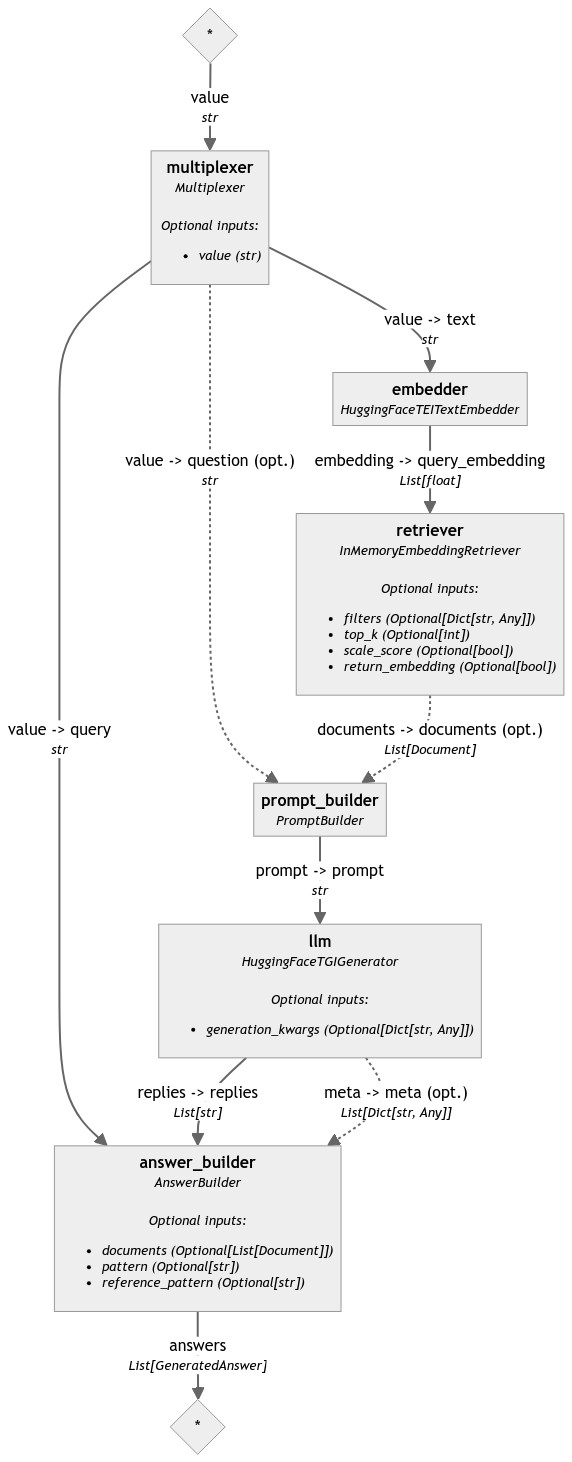

In [8]:
from IPython.display import Image

pipe.draw("pipeline_with_multiplexer.png")
Image("pipeline_with_multiplexer.png", width=300)

## Running the Pipeline with a Multiplexer

Run the pipeline that you updated with a Multiplexer. This time, instead of passing the query to `prompt_builder`, `retriever` and `answer_builder` seperately, you only need to pass it to the `multiplexer`. As a result, you will get the same answer.

In [9]:
pipe.run({"multiplexer": {"value": "Where does Mark live?"}})

{'answer_builder': {'answers': [GeneratedAnswer(data='\nMark lives in Berlin.', query='Where does Mark live?', documents=[], meta={'model': 'mistralai/Mistral-7B-Instruct-v0.2', 'index': 0, 'finish_reason': 'eos_token', 'usage': {'completion_tokens': 7, 'prompt_tokens': 133, 'total_tokens': 140}})]}}

## What's next

🎉 Congratulations! You've simplified your pipeline run with a Multiplexer!

If you liked this tutorial, there's more to learn about Haystack 2.0:
- [Creating a Hybrid Retrieval Pipeline](https://haystack.deepset.ai/tutorials/33_hybrid_retrieval)
- [Building Fallbacks to Websearch with Conditional Routing](https://haystack.deepset.ai/tutorials/36_building_fallbacks_with_conditional_routing)
- [Model-Based Evaluation of RAG Pipelines](https://haystack.deepset.ai/tutorials/35_model_based_evaluation_of_rag_pipelines)

To stay up to date on the latest Haystack developments, you can [sign up for our newsletter](https://landing.deepset.ai/haystack-community-updates?utm_campaign=developer-relations&utm_source=tutorial&utm_medium=multiplexer) or [join Haystack discord community](https://discord.gg/haystack).

Thanks for reading!